In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [44]:
import RNA
from forgi.graph import bulge_graph
import subprocess
from IPython.display import Image, SVG
import os
import tempfile

In [7]:
seq = 'CGCUUCAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUGAAGUG'
structure, energy = RNA.fold(seq)
print(seq)
print(structure)

CGCUUCAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUGAAGUG
(((((((((...((((((.........))))))........((((((.......))))))..)))))))))


In [17]:
bg = bulge_graph.from_fasta_text('>seq\n' + seq + '\n' + structure)
print(bg.to_bg_string())

name seq
length 71
seq CGCUUCAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUGAAGUG
seq_ids A:1 A:2 A:3 A:4 A:5 A:6 A:7 A:8 A:9 A:10 A:11 A:12 A:13 A:14 A:15 A:16 A:17 A:18 A:19 A:20 A:21 A:22 A:23 A:24 A:25 A:26 A:27 A:28 A:29 A:30 A:31 A:32 A:33 A:34 A:35 A:36 A:37 A:38 A:39 A:40 A:41 A:42 A:43 A:44 A:45 A:46 A:47 A:48 A:49 A:50 A:51 A:52 A:53 A:54 A:55 A:56 A:57 A:58 A:59 A:60 A:61 A:62 A:63 A:64 A:65 A:66 A:67 A:68 A:69 A:70 A:71
define s0 1 9 63 71
define m0 10 12
define s1 13 18 28 33
define h0 19 27
define m1 34 41
define s2 42 47 55 60
define h1 48 54
define m2 61 62
connect s0 m0 m2
connect s1 m0 h0 m1
connect s2 m1 h1 m2



In [19]:
print(bg.to_neato_string())

graph G {
	graph [overlap=false,splines=true];
	node [shape=box];
	{node [style=filled,fillcolor="#B3E2CD",fontsize=20,label="s0\n(9)"] s0};
	{node [style=filled,fillcolor="#B3E2CD",fontsize=20,label="s1\n(6)"] s1};
	{node [style=filled,fillcolor="#B3E2CD",fontsize=20,label="s2\n(6)"] s2};
	{node [style=filled,shape=circle,fillcolor="#F4CAE4",fontsize=20,label="m0 \n(3)"] m0};
	{node [style=filled,shape=circle,fillcolor="#F4CAE4",fontsize=20,label="m1 \n(8)"] m1};
	{node [style=filled,shape=circle,fillcolor="#F4CAE4",fontsize=20,label="m2 \n(2)"] m2};
	{node [style=filled,shape=circle,fillcolor="#CBD5E8",fontsize=20,label="h0 \n(9)"] h0};
	{node [style=filled,shape=circle,fillcolor="#CBD5E8",fontsize=20,label="h1 \n(7)"] h1};
	s0 -- m2;
	s0 -- m0;
	s1 -- m1;
	s1 -- h0;
	s1 -- m0;
	s2 -- h1;
	s2 -- m1;
	s2 -- m2;
}


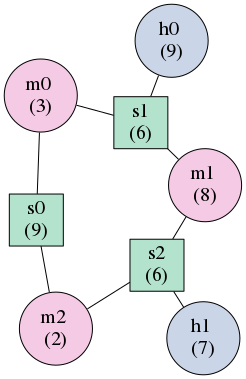

In [30]:
def render_neato(s, format='png', dpi=100):
    p = subprocess.Popen(['neato', '-T', format, '-o', '/dev/stdout', '-Gdpi={}'.format(dpi)], 
                         stdout=subprocess.PIPE, stdin=subprocess.PIPE)
    image, _ = p.communicate(bytes(s, encoding='utf-8'))
    return image

Image(render_neato(bg.to_neato_string(), dpi=72), format='png')

In [ ]:
os.tem

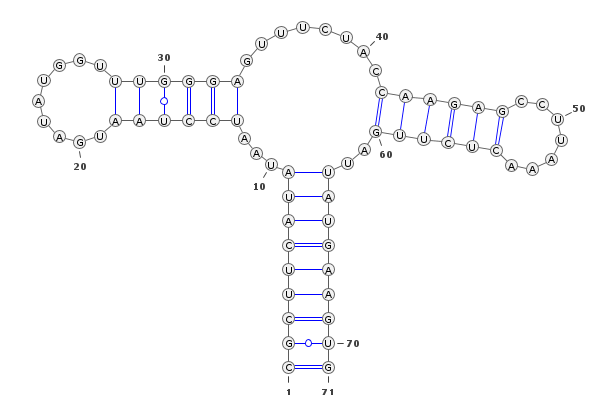

In [75]:
def plot_RNA(seq, structure, dpi=72):
    if RNA.PS_rna_plot(seq, structure, 'rna.ps') == 0:
        raise ValueError('PS_rna_plot() failed')
    with open('rna.ps', 'r') as f:
        ps = f.read()
    p = subprocess.Popen(['gs', '-sDEVICE=png16m', '-o', 'rna.png', '-r{}'.format(dpi),
                          '-dGraphicsAlphaBits=4', '-dTextAlphaBits=4', 'rna.ps'])
    p.wait()
    os.unlink('rna.ps')
    with open('rna.png', 'rb') as f:
        image = f.read()
    os.unlink('rna.png')
    return image

def varna(seq, structure, varna_jar='VARNAv3-93.jar', resolution=1.5):
    p = subprocess.Popen(['java', '-cp', varna_jar, 'fr.orsay.lri.varna.applications.VARNAcmd',
                         '-sequenceDBN', seq, '-structureDBN', structure,
                         '-resolution', str(resolution), '-o', 'rna.png'])
    p.wait()
    with open('rna.png', 'rb') as f:
        image = f.read()
    os.unlink('rna.png')
    return image

Image(varna(seq, structure, varna_jar='../tools/VARNAv3-93.jar'), format='png')

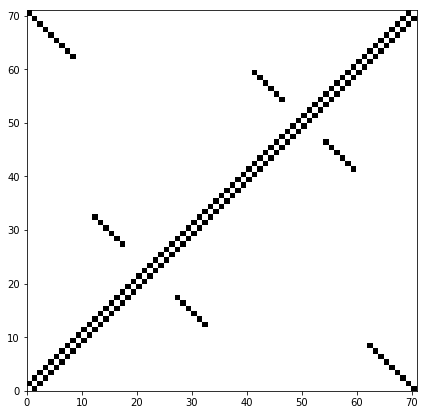

In [113]:
def pair_table_to_adj_mat(pair_table):
    L = len(pair_table) - 1
    m = np.zeros((L, L), dtype=np.int32)
    for i in range(1, L + 1):
        if pair_table[i] > 0:
            m[i - 1, pair_table[i] - 1] = 1
    m[np.r_[:(L - 1)], np.r_[1:L]] = 1
    m[np.r_[1:L], np.r_[:(L - 1)]] = 1
    return m

def pair_table_to_adj_list(pair_table):
    L = len(pair_table) - 1
    adj_list = [[] for i in range(L)]
    for i in range(1, L + 1):
        if i < L:
            adj_list[i - 1].append(i)
            adj_list[i].append(i - 1)
        if pair_table[i] > 0:
            adj_list[i - 1].append(pair_table[i] - 1)
    return adj_list

adj_mat = pair_table_to_adj_mat(bg.to_pair_table())
fig, ax = plt.subplots(figsize=(7, 7))
ax.pcolormesh(adj_mat, cmap=cm.Greys)

In [114]:
pair_table_to_adj_list(bg.to_pair_table())

[[1, 70],
 [0, 2, 69],
 [1, 3, 68],
 [2, 4, 67],
 [3, 5, 66],
 [4, 6, 65],
 [5, 7, 64],
 [6, 8, 63],
 [7, 9, 62],
 [8, 10],
 [9, 11],
 [10, 12],
 [11, 13, 32],
 [12, 14, 31],
 [13, 15, 30],
 [14, 16, 29],
 [15, 17, 28],
 [16, 18, 27],
 [17, 19],
 [18, 20],
 [19, 21],
 [20, 22],
 [21, 23],
 [22, 24],
 [23, 25],
 [24, 26],
 [25, 27],
 [26, 28, 17],
 [27, 29, 16],
 [28, 30, 15],
 [29, 31, 14],
 [30, 32, 13],
 [31, 33, 12],
 [32, 34],
 [33, 35],
 [34, 36],
 [35, 37],
 [36, 38],
 [37, 39],
 [38, 40],
 [39, 41],
 [40, 42, 59],
 [41, 43, 58],
 [42, 44, 57],
 [43, 45, 56],
 [44, 46, 55],
 [45, 47, 54],
 [46, 48],
 [47, 49],
 [48, 50],
 [49, 51],
 [50, 52],
 [51, 53],
 [52, 54],
 [53, 55, 46],
 [54, 56, 45],
 [55, 57, 44],
 [56, 58, 43],
 [57, 59, 42],
 [58, 60, 41],
 [59, 61],
 [60, 62],
 [61, 63, 8],
 [62, 64, 7],
 [63, 65, 6],
 [64, 66, 5],
 [65, 67, 4],
 [66, 68, 3],
 [67, 69, 2],
 [68, 70, 1],
 [69, 0]]

In [104]:
list(bg.adjacent_stem_pairs_iterator())

[('s1', 'm0', 's0'), ('s2', 'm1', 's1'), ('s2', 'm2', 's0')]

In [105]:
list(bg.iter_elements_along_backbone())

/apps/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: generator 'BulgeGraph.iter_elements_along_backbone' raised StopIteration
  """Entry point for launching an IPython kernel.


['s0', 'm0', 's1', 'h0', 's1', 'm1', 's2', 'h1', 's2', 'm2', 's0']

In [106]:
list(bg.sorted_element_iterator())

['s0', 'm0', 's1', 'h0', 'm1', 's2', 'h1', 'm2']

In [107]:
bg.to_element_string()

'sssssssssmmmsssssshhhhhhhhhssssssmmmmmmmmsssssshhhhhhhssssssmmsssssssss'

In [ ]:
ax.